In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [14]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	#'spread_line',
	#'total_line',
]

x_cols = game_context_cols #+ ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] # + rusher_stat_cols + ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [15]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 40 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	--{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	--{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	--{Quack.select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp 
	--join team_feats as t 
	--on pbp.posteam = t.team
	--and pbp.game_id = t.game_id
	--join opp_feats as o
	--on pbp.defteam = o.opponent_team
	--and pbp.game_id = o.game_id
	--join player_weekly_agg as r
	--on r.game_id = pbp.game_id
	--and pbp.rusher_player_id = r.gsis_id
	--and r.team = pbp.posteam
	where pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")


X = rushes[x_cols]
y = rushes['yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
#X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
#y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [ ]:
def get_sample(num_samples):
	idx = np.random.randint(0,len(X_tensor), num_samples)
	return X_tensor[idx]

model = maskedModel(
	n_in=len(x_cols),
	n_out=140,
	n_hidden=64,
)

c = get_sample(5)
pred = model(c)

In [19]:

probs = torch.randn(9, 140)       # [batch, features]
probs = torch.softmax(probs, dim=1)
ydstogo = torch.randint(0, 140, (9,))  # [batch]
print(ydstogo)

# Create a mask
mask = torch.arange(probs.size(1)).unsqueeze(0) >= ydstogo.unsqueeze(1)  # [9, 140]

# Apply mask
masked_output = probs * mask

print(masked_output.sum(1))


tensor([119,  22,  79,  11,  47,  56,  14, 102, 103])
tensor([0.1551, 0.8109, 0.4313, 0.9416, 0.6918, 0.5034, 0.9305, 0.2414, 0.2108])


In [ ]:
class maskedModel(nn.Module):
	def __init__(self, n_in=11, n_out=140, n_hidden=512):
		super(maskedModel, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		#ResBlock(n_hidden),
		#ResBlock(n_hidden),
		#ResBlock(n_hidden),
		)
		self.output_layer  = nn.Linear(n_hidden, n_out)
		self.td_head = nn.Sequential(nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden), nn.Linear(n_hidden,1))
		
	def forward(self, x):
		# Extract the feature to pass to the final layer (e.g., the first feature)
		yardline = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
		#td_bin = (yardline + 40).long().squeeze(1)
		#td_logits = self.td_head(x)
		x = self.main_layers(x)
		logits = self.output_layer(x)
		#batch_indices = torch.arange(logits.size(0), device=logits.device)
		#logits[batch_indices, td_bin] = logits[batch_indices, td_bin] + td_logits.squeeze(1)
		
		yard_values = torch.arange(-40, self.n_out - 40, device=x.device).float().unsqueeze(0)
		mask = (yard_values <= yardline).float()
		logits = logits + (mask - 1) * 1e9

		return logits

In [37]:
torch.arange(-40, 140 - 40)

tensor([-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27,
        -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
        -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99])

In [ ]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	#smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCEWithLogitsLoss()
	fd_criterion = nn.BCEWithLogitsLoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.007)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	train_y_smooth = y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	test_y_smooth = y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y, batch_y_smooth = Xtr[batch_idx], train_y[batch_idx], train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= (batch_x[:,1] + 40).unsqueeze(1)  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= (batch_x[:,0] + 40).unsqueeze(1)  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 1
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y_smooth)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) 
			loss = classifier_loss + mean_loss #+ td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y_smooth).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

		test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
	plt.hist(test_preds, alpha=0.5, color='r')
	plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
	return model

cuda
tensors loading
splitting batches
tensor(0.2376, device='cuda:0')
tensor(0.0326, device='cuda:0')
Epoch 1/8, Classifier Loss: 4.5499, MSE Loss: 39.1627
Test Loss: 4.7024, Test Accuracy: 0.0971
Epoch 2/8, Classifier Loss: 4.3033, MSE Loss: 38.3358
Test Loss: 4.3824, Test Accuracy: 0.1161
Epoch 3/8, Classifier Loss: 3.5671, MSE Loss: 38.2683
Test Loss: 6.2058, Test Accuracy: 0.0907
Epoch 4/8, Classifier Loss: 3.3650, MSE Loss: 38.1858
Test Loss: 3.0367, Test Accuracy: 0.1383
Epoch 5/8, Classifier Loss: 2.9642, MSE Loss: 38.1156
Test Loss: 2.9262, Test Accuracy: 0.1208
Epoch 6/8, Classifier Loss: 2.8563, MSE Loss: 38.0883
Test Loss: 2.8447, Test Accuracy: 0.1282
Epoch 7/8, Classifier Loss: 2.8315, MSE Loss: 38.0611
Test Loss: 2.8241, Test Accuracy: 0.1400
Epoch 8/8, Classifier Loss: 2.8226, MSE Loss: 38.0103
Test Loss: 2.8374, Test Accuracy: 0.1400


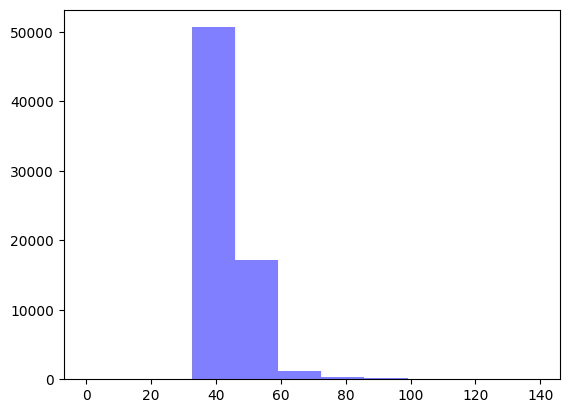

In [27]:
rush_yards_model = train_model(X_tensor,y_tensor, n_in=len(x_cols), n_out=140, n_hidden = 128, epochs=8)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 

In [28]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

true_first=np.float64(0.37)
true_td=np.float64(0.34)
Actual mean: 1.37, Model mean: 1.27
number of datapoints: 2504


(-10.0, 23.0)

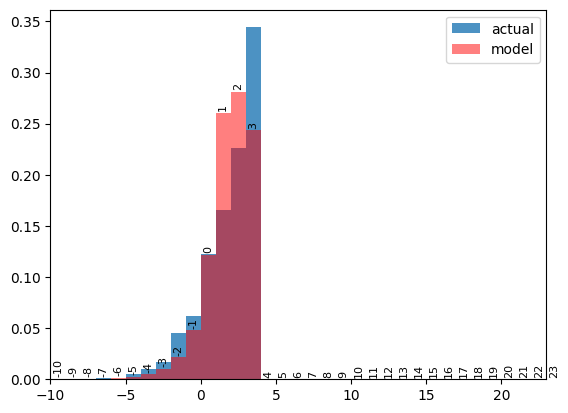

In [106]:
def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,3))].reset_index(drop=True)
	true_first = sample['first_down'].mean().round(2)
	true_td = sample['touchdown'].mean().round(2)
	print(f"{true_first=}")
	print(f"{true_td=}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
     
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 3
down = 3
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')

# Add index labels on top of bars
for i, p in enumerate(probs):
    yard_val = -40 + i
    if -10 <= yard_val <= yard + 20:  # only label visible range
        plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
                 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-10,yard+20)

In [110]:
def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,3))].reset_index(drop=True)
	true_first = sample['first_down'].mean().round(2)
	true_td = sample['touchdown'].mean().round(2)
	print(f"{true_first=}")
	print(f"{true_td=}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	return probs, sample['yardline_100'].values
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 3
down = 3
probs, ydl = sample_model_yardline(yard, down)

true_first=np.float64(0.37)
true_td=np.float64(0.34)


In [111]:
probs[0]

array([1.2869335e-04, 1.2954386e-04, 1.3045447e-04, 1.3136896e-04,
       1.3231386e-04, 1.3329694e-04, 1.3546050e-04, 1.3539083e-04,
       1.3628903e-04, 1.3734827e-04, 1.4108761e-04, 1.4027998e-04,
       1.5214954e-04, 1.4287941e-04, 1.4775114e-04, 1.4406446e-04,
       1.4526983e-04, 1.4800922e-04, 1.4775578e-04, 1.4912938e-04,
       1.5593795e-04, 1.5168931e-04, 1.7123601e-04, 1.5462418e-04,
       1.5959275e-04, 1.5733675e-04, 1.6483616e-04, 1.7034277e-04,
       2.0641209e-04, 2.4715994e-04, 3.1854436e-04, 4.4863790e-04,
       4.8645271e-04, 5.8891828e-04, 1.4043025e-03, 2.0759937e-03,
       4.7603748e-03, 1.0282198e-02, 2.1517346e-02, 4.7504477e-02,
       1.1826762e-01, 2.6156905e-01, 2.8071404e-01, 2.4553433e-01,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [112]:
probs[np.arange(len(probs)), ydl.astype(int) + 30].mean()

np.float32(0.0006021935)

In [95]:
test = np.array([[0,1,2,3],[4,5,6,7]])
test[:,[1,3]]

array([[1, 3],
       [5, 7]])

In [ ]:
#td prod


a = np.arange(4 * 2).reshape(2, 4)
cols = np.array([1,3])

out = a[np.arange(len(cols)), cols]
out

array([1, 7])

In [ ]:
#fd prob

probs = np.random.rand(3, 10)
starts = np.array([4, 8, 2])  # start index for each row
def get_fd_chance(probs, ydl):
    
	# build a mask for summing
	cols = np.arange(probs.shape[1])
	mask = cols >= starts[:, None]   # shape (3, 10), True where col >= start

	sums = (probs * mask).sum(axis=1)
	return sums
print(sums)


[2.93837483 1.06331011 2.82127522]
